In [1]:
import pandas as pd
import numpy as np
import sklearn
from lightgbm import LGBMClassifier

In [2]:
# Features - Data Read
features = pd.read_parquet("DATA/joined_features_2021-10-01.parquet")

# Labels - Data Read & Select only KEY and Label
labels = pd.read_parquet("DATA/dormant-202201-ch-sni-only")
labels = labels[["AccountNumber", "DORMANT"]]

### Join datasets together

In [3]:
df = features.join(labels.set_index("AccountNumber"), "ACCOUNT_NUMBER", "inner")

In [4]:
print(len(df.index))
print(df["ACCOUNT_NUMBER"].nunique())

636609
636609


In [5]:
df = df.drop_duplicates(["ACCOUNT_NUMBER"])
df

,ACCOUNT_NUMBER,TXN_FIRST_OF_MONTH,NO_TXN,TOTAL_INFLOW,TOTAL_OUTFLOW,MIN_BALANCE,MAX_BALANCE,NO_TXN_LAG_1,NO_TXN_DIFF_1,TOTAL_INFLOW_LAG_1,...,TOTAL_OUTFLOW_DIFF_2,MIN_BALANCE_LAG_2,MIN_BALANCE_DIFF_2,MAX_BALANCE_LAG_2,MAX_BALANCE_DIFF_2,LAST_TXN_MONTH,SbuSegmentCode,SicCode,IndustryCode,DORMANT
0,0000009269746123,2021-03-01,1,0.00,-240.00,172.69,172.69,NaN,NaN,None,...,None,None,None,None,None,2021-03-01,H,96140.0,96140,True
1,0000009278119965,2021-03-01,2,10000.00,-10000.00,21.20,10021.20,NaN,NaN,None,...,None,None,None,None,None,2021-03-01,E,0.0,00000,False
2,0000000018380123,2021-04-01,1,510.00,0.00,6658.16,6658.16,NaN,NaN,None,...,None,None,None,None,None,2021-04-01,None,NaN,None,False
3,0000000021572217,2021-04-01,1,2486.40,0.00,4403.94,4403.94,NaN,NaN,None,...,None,None,None,None,None,2021-04-01,None,NaN,None,True
4,0000009068737731,2021-04-01,2,80.94,0.00,21391.32,21407.86,NaN,NaN,None,...,None,None,None,None,None,2021-04-01,F,0.0,00000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636604,0000038134310178,2021-09-01,9,31405.34,-39900.00,1954.68,36854.68,8.0,-1.0,31405.42,...,8480.00,11293.92,9339.24,41213.92,4359.24,2021-09-01,F,0.0,00000,False
636605,0000038142590333,2021-09-01,82,593855.03,-597300.34,12432.32,211283.88,68.0,-14.0,703752.27,...,122475.52,13565.74,1133.42,193565.74,-17718.14,2021-09-01,F,0.0,00000,False
636606,0000038142761278,2021-09-01,65,79375.79,-47670.94,6762.24,50143.24,64.0,-1.0,2525372.06,...,-10080.96,432369.98,425607.74,605418.81,555275.57,2021-09-01,E,0.0,00000,False
636607,0000038149650528,2021-09-01,21,44253.46,-42402.92,5174.82,23150.92,24.0,3.0,27165.28,...,12208.61,5080.74,-94.08,23590.05,439.13,2021-09-01,F,0.0,00000,False


### Filter out only customers who have transacted in the last month

In [6]:
import datetime

df = df[df["LAST_TXN_MONTH"] == datetime.date(2021, 9, 1)]
len(df.index)

601109

### Feature Preprocessing

In [7]:
X = df.drop([
    "ACCOUNT_NUMBER",
    "TXN_FIRST_OF_MONTH",
    "LAST_TXN_MONTH",
    "DORMANT"
], axis=1)
y = df["DORMANT"]

X.columns

Index(['NO_TXN', 'TOTAL_INFLOW', 'TOTAL_OUTFLOW', 'MIN_BALANCE', 'MAX_BALANCE',
       'NO_TXN_LAG_1', 'NO_TXN_DIFF_1', 'TOTAL_INFLOW_LAG_1',
       'TOTAL_INFLOW_DIFF_1', 'TOTAL_OUTFLOW_LAG_1', 'TOTAL_OUTFLOW_DIFF_1',
       'MIN_BALANCE_LAG_1', 'MIN_BALANCE_DIFF_1', 'MAX_BALANCE_LAG_1',
       'MAX_BALANCE_DIFF_1', 'NO_TXN_LAG_2', 'NO_TXN_DIFF_2',
       'TOTAL_INFLOW_LAG_2', 'TOTAL_INFLOW_DIFF_2', 'TOTAL_OUTFLOW_LAG_2',
       'TOTAL_OUTFLOW_DIFF_2', 'MIN_BALANCE_LAG_2', 'MIN_BALANCE_DIFF_2',
       'MAX_BALANCE_LAG_2', 'MAX_BALANCE_DIFF_2', 'SbuSegmentCode', 'SicCode',
       'IndustryCode'],
      dtype='object')

In [8]:
def preprocess(features):
    categorical = [
        "SbuSegmentCode",
        "SicCode",
        "IndustryCode"
    ]

    for i,c in enumerate(features.columns):
        if c in categorical:
            features[c] = features[c].fillna(-1)
            features[c] = features[c].astype("category")
        else:
            avg = np.mean(features[c])
            features[c] = features[c].fillna(avg).astype("int")
            
    return features

In [9]:
X = preprocess(X)

### Data Exploration

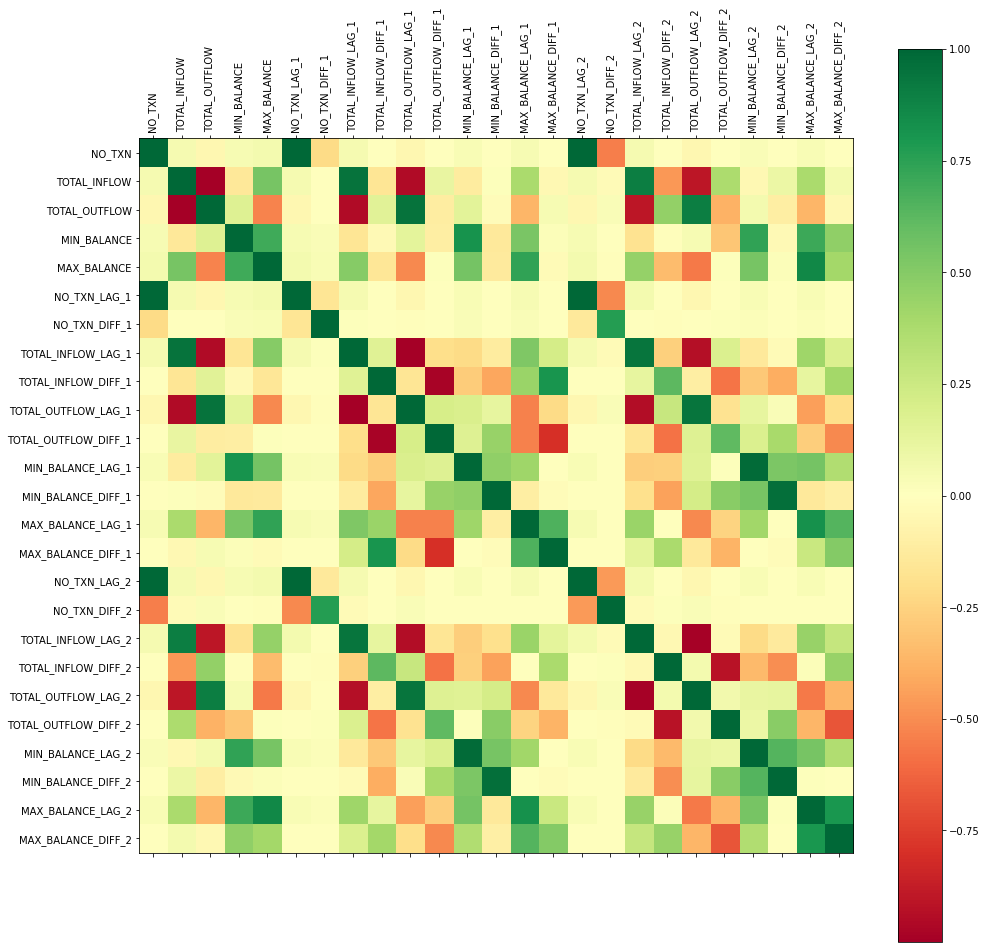

In [10]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,20)

corr = X.corr()
plt.matshow(corr, cmap="RdYlGn")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.colorbar()
plt.show()

### Model Train

In [11]:
# For train test split 
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)

X_train = X
y_train = y

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import average_precision_score

# Parameters to estimate
estimated_params = [
    {'max_depth': [5, 6, 7]},
    {'num_leaves': [30, 40, 50], 'min_data_in_leaf': [500, 1000, 2000]},
    {'num_iterations': [200, 5000, 1000]},
    {'max_bin': [50, 100, 150, 200, 250]},
    {'lambda_l1': [0, 0.1, 0.2, 0.5, 1.0]},
    {'subsample': [0.1, 0.2, 0.3]},
    {'feature_fraction': [0.2, 0.3, 0.4, 0.5, 1.0]}
]

# Parameters which we use
default_params = {
    # Previous Iterations of CV:
    'n_estimators': 600,
    'max_depth': 5,
    'learning_rate': 0.05,

    "random_state": 7,
    'n_jobs': 8,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'is_unbalance': True
}

# Tree training
used_params = default_params.copy()
for i, current_params in enumerate(estimated_params):
    print(f"=== ITERATION #{i} ===")
    model = LGBMClassifier(**used_params)

    print(f"Evaluating parameter grid: {current_params}")
    tuning = GridSearchCV(estimator=model, param_grid=current_params, scoring='average_precision', n_jobs=15, cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True))
    tuning.fit(X_train, y_train)

    print(f"Best parameters {tuning.best_params_} achieved {tuning.best_score_:.3f} Average Precision")
    used_params.update(tuning.best_params_)
    print(f"Continuing training with {used_params}")

=== ITERATION #0 ===
Evaluating parameter grid: {'max_depth': [5, 6, 7]}
Best parameters {'max_depth': 7} achieved 0.374 Average Precision
Continuing training with {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'random_state': 7, 'n_jobs': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'is_unbalance': True}
=== ITERATION #1 ===
Evaluating parameter grid: {'num_leaves': [30, 40, 50], 'min_data_in_leaf': [500, 1000, 2000]}
Best parameters {'min_data_in_leaf': 500, 'num_leaves': 50} achieved 0.377 Average Precision
Continuing training with {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'random_state': 7, 'n_jobs': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'is_unbalance': True, 'min_data_in_leaf': 500, 'num_leaves': 50}
=== ITERATION #2 ===
Evaluating parameter grid: {'num_iterations': [200, 5000, 1000]}


/home/ab011bt/miniconda3/envs/pyspark/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Best parameters {'num_iterations': 200} achieved 0.377 Average Precision
Continuing training with {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'random_state': 7, 'n_jobs': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'is_unbalance': True, 'min_data_in_leaf': 500, 'num_leaves': 50, 'num_iterations': 200}
=== ITERATION #3 ===
Evaluating parameter grid: {'max_bin': [50, 100, 150, 200, 250]}


/home/ab011bt/miniconda3/envs/pyspark/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Best parameters {'max_bin': 250} achieved 0.378 Average Precision
Continuing training with {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'random_state': 7, 'n_jobs': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'is_unbalance': True, 'min_data_in_leaf': 500, 'num_leaves': 50, 'num_iterations': 200, 'max_bin': 250}
=== ITERATION #4 ===
Evaluating parameter grid: {'lambda_l1': [0, 0.1, 0.2, 0.5, 1.0]}


/home/ab011bt/miniconda3/envs/pyspark/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Best parameters {'lambda_l1': 0.1} achieved 0.379 Average Precision
Continuing training with {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'random_state': 7, 'n_jobs': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'is_unbalance': True, 'min_data_in_leaf': 500, 'num_leaves': 50, 'num_iterations': 200, 'max_bin': 250, 'lambda_l1': 0.1}
=== ITERATION #5 ===
Evaluating parameter grid: {'subsample': [0.1, 0.2, 0.3]}


/home/ab011bt/miniconda3/envs/pyspark/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Best parameters {'subsample': 0.1} achieved 0.379 Average Precision
Continuing training with {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'random_state': 7, 'n_jobs': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'is_unbalance': True, 'min_data_in_leaf': 500, 'num_leaves': 50, 'num_iterations': 200, 'max_bin': 250, 'lambda_l1': 0.1, 'subsample': 0.1}
=== ITERATION #6 ===
Evaluating parameter grid: {'feature_fraction': [0.2, 0.3, 0.4, 0.5, 1.0]}


/home/ab011bt/miniconda3/envs/pyspark/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Best parameters {'feature_fraction': 0.3} achieved 0.381 Average Precision
Continuing training with {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'random_state': 7, 'n_jobs': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'is_unbalance': True, 'min_data_in_leaf': 500, 'num_leaves': 50, 'num_iterations': 200, 'max_bin': 250, 'lambda_l1': 0.1, 'subsample': 0.1, 'feature_fraction': 0.3}


In [13]:
model = LGBMClassifier(**used_params)
model.fit(X_train, y_train)

/home/ab011bt/miniconda3/envs/pyspark/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(feature_fraction=0.3, is_unbalance=True, lambda_l1=0.1,
               learning_rate=0.05, max_bin=250, max_depth=7,
               min_data_in_leaf=500, n_estimators=600, n_jobs=8,
               num_iterations=200, num_leaves=50, objective='binary',
               random_state=7, subsample=0.1)

### Feature Importance

In [14]:
print(f"=== FEATURE IMPORTANCE ===")
feature_importances = list(zip(X_train.columns, model.feature_importances_))
for feature, importance in sorted(feature_importances, key=lambda x: x[1], reverse=True):
    print(f"{feature:>30}: {importance}")

=== FEATURE IMPORTANCE ===
                       SicCode: 1105
                  IndustryCode: 931
                   MIN_BALANCE: 584
             MIN_BALANCE_LAG_1: 559
            TOTAL_INFLOW_LAG_1: 544
             MAX_BALANCE_LAG_2: 494
                  NO_TXN_LAG_2: 485
             MIN_BALANCE_LAG_2: 409
           TOTAL_OUTFLOW_LAG_2: 390
                  TOTAL_INFLOW: 354
            MAX_BALANCE_DIFF_2: 323
            TOTAL_INFLOW_LAG_2: 309
             MAX_BALANCE_LAG_1: 273
           TOTAL_OUTFLOW_LAG_1: 269
            MIN_BALANCE_DIFF_1: 261
            MIN_BALANCE_DIFF_2: 257
                  NO_TXN_LAG_1: 240
            MAX_BALANCE_DIFF_1: 232
                   MAX_BALANCE: 220
           TOTAL_INFLOW_DIFF_1: 190
                SbuSegmentCode: 187
                 NO_TXN_DIFF_1: 164
                        NO_TXN: 163
                 TOTAL_OUTFLOW: 156
          TOTAL_OUTFLOW_DIFF_2: 136
                 NO_TXN_DIFF_2: 133
          TOTAL_OUTFLOW_DIFF_1: 124


### Evaluation Dataset

In [15]:
# Features - Data Read
tst_features = pd.read_parquet("DATA/joined_features_2022-01-01.parquet")

# Labels - Data Read & Select only KEY and Label
tst_labels = pd.read_parquet("DATA/dormant-202203-ch-sni-only")
tst_labels = tst_labels[["AccountNumber", "DORMANT"]]

In [16]:
tst_df = tst_features.join(tst_labels.set_index("AccountNumber"), "ACCOUNT_NUMBER", "inner")
tst_df = tst_df.drop_duplicates(["ACCOUNT_NUMBER"])

In [17]:
import datetime
tst_df = tst_df[tst_df["LAST_TXN_MONTH"] == datetime.date(2021, 12, 1)]

In [18]:
X_test = tst_df.drop([
    "TXN_FIRST_OF_MONTH",
    "LAST_TXN_MONTH",
    "DORMANT"
], axis=1)

X_test = X_test.set_index("ACCOUNT_NUMBER")
y_test = tst_df["DORMANT"]

In [19]:
X_test = preprocess(X_test)

### Evaluation

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
def roc_auc_plot(model, testX, testy):
    lr_probs = model.predict_proba(testX)
    lr_probs = lr_probs[:, 1]
    
    ns_probs = [0 for _ in range(len(testy))]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    
    print('Random: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    
    pyplot.plot(ns_fpr, ns_tpr, label='Random')
    pyplot.plot(lr_fpr, lr_tpr, label='Model')
    
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    
    pyplot.legend()
    pyplot.show()

Random: ROC AUC=0.500
Model: ROC AUC=0.937


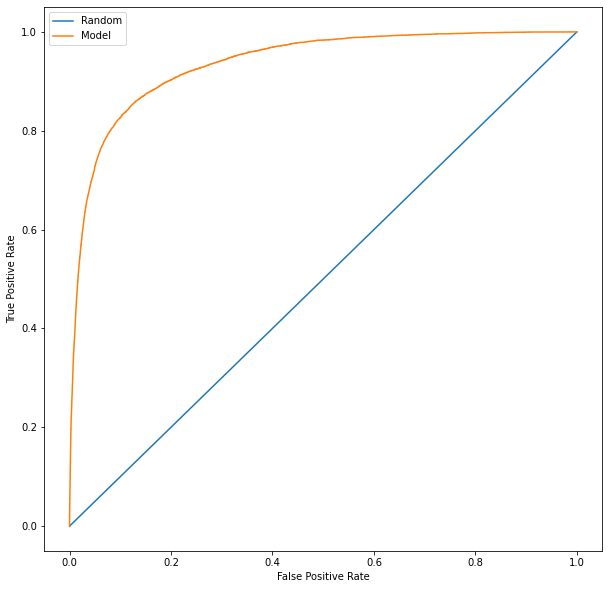

In [21]:
plt.rcParams["figure.figsize"] = (10,10)
roc_auc_plot(model, X_test, y_test)

In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.91      0.95    595797
        True       0.16      0.81      0.27     12453

    accuracy                           0.91    608250
   macro avg       0.58      0.86      0.61    608250
weighted avg       0.98      0.91      0.94    608250



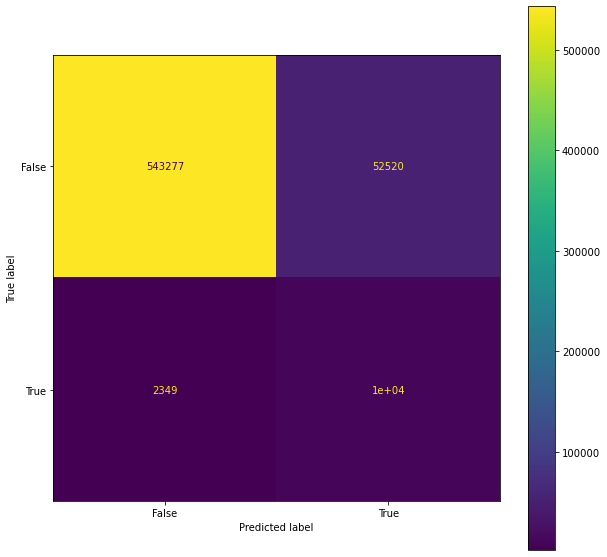

In [23]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)

### SHAP

In [24]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

/home/ab011bt/miniconda3/envs/pyspark/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


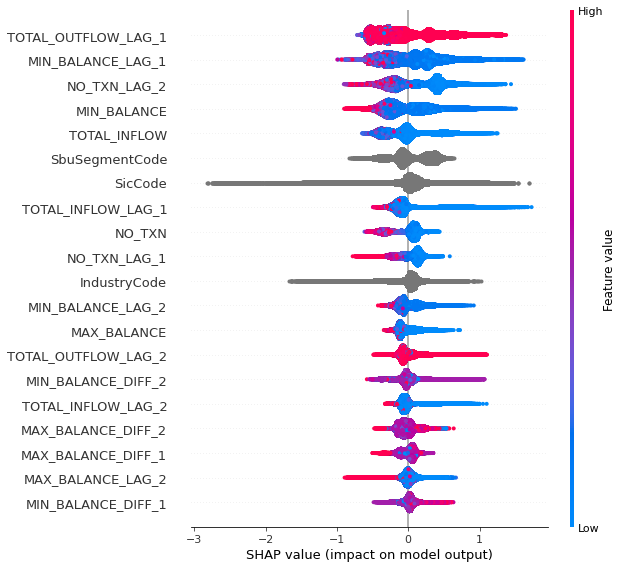

In [25]:
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns)

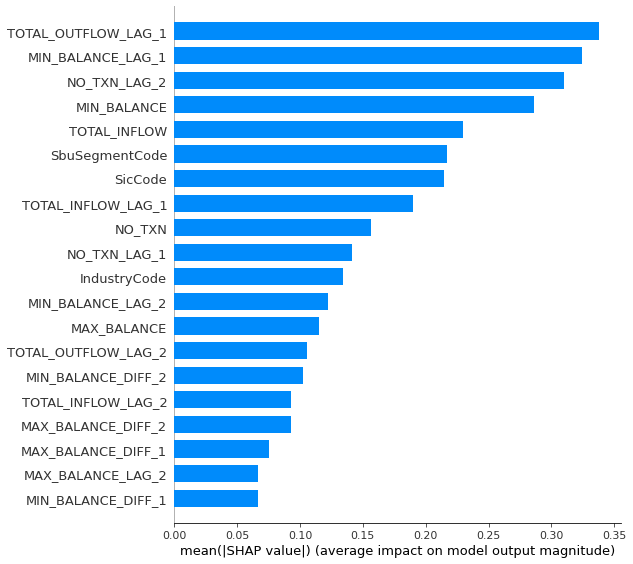

In [26]:
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, plot_type='bar')

### Top N Chart

In [27]:
propensities = model.predict_proba(X_test)[:, 1]
data = {"ACCOUNT_NUMBER": X_test.index, "PROPENSITY": propensities}
propensities = pd.DataFrame(data)

In [28]:
tst_labels = pd.read_parquet("DATA/dormant-202203-ch-sni-only")
tst_labels = tst_labels[["AccountNumber", "DORMANT"]]

df_eval = propensities.join(tst_labels.set_index("AccountNumber"), "ACCOUNT_NUMBER", "inner")

In [29]:
propensities = {
    "PoC Model": df_eval.sort_values(by="PROPENSITY", ascending=False)
}



=== TOP 5k predictions: ===

Evaluating: PoC Model
Customers: 5000
Precision @5k: 56.720%
# Dormant: 2836


=== TOP 10k predictions: ===

Evaluating: PoC Model
Customers: 10000
Precision @10k: 46.070%
# Dormant: 4607


=== TOP 20k predictions: ===

Evaluating: PoC Model
Customers: 20000
Precision @20k: 34.955%
# Dormant: 6991


=== TOP 40k predictions: ===

Evaluating: PoC Model
Customers: 40000
Precision @40k: 22.863%
# Dormant: 9145


=== TOP 80k predictions: ===

Evaluating: PoC Model
Customers: 80000
Precision @80k: 13.150%
# Dormant: 10520


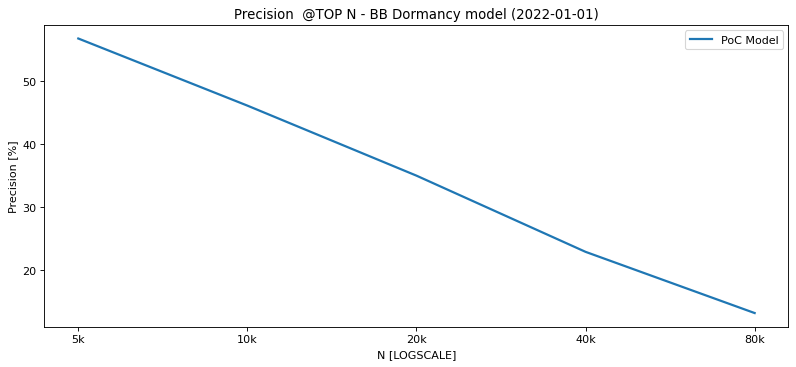

In [30]:
num_test = 5
accs = {f:[] for f in propensities}

# Calculate Results
for n in range(-1, num_test - 1):
    top_n = int((2**n) * 10)
    
    print(f"\n\n=== TOP {top_n}k predictions: ===")
    for f, prop in propensities.items():
        print(f"\nEvaluating: {f}")
        prop_topN = prop.iloc[:top_n * 1000]
        acc = prop_topN['DORMANT'].mean()
        
        print(f"Customers: {len(prop_topN.index)}")
        print(f"Precision @{top_n}k: {100 * acc:.3f}%")
        print(f"# Dormant: {prop_topN['DORMANT'].sum()}")
    
        accs[f].append(acc)
    
# Plot Results
plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')

for f, acc in accs.items():
    plt.plot(np.arange(num_test), 100 * np.array(acc), linewidth=2, label=f)

plt.xticks(np.arange(num_test), [f"{int((2**n) * 10)}k" for n in range(-1, num_test - 1)])
plt.title("Precision  @TOP N - BB Dormancy model (2022-01-01)")
plt.xlabel("N [LOGSCALE]")
plt.ylabel("Precision [%]")    
    
plt.legend()
plt.show()